In [7]:
!pip install torch transformers peft datasets accelerate bitsandbytes scipy matplotlib


In [8]:
!pip install -q triton

In [9]:
from data_manager import DataManager
# Reload to ensure we use the latest fixed classes
import core_blockwise
import importlib
importlib.reload(core_blockwise)
from core_blockwise import FederatedClientBlockWise, ServerBlockWise
import torch
import gc

# 1. Setup Data
print("--- Setting up Data & Server ---")
dm = DataManager()
datasets = dm.setup_real_world_benchmark()

# 2. Setup Server
server = ServerBlockWise(num_clients=10)

# 3. Setup 10 Clients (Heterogeneous)
clients_baseline = []
for i in range(10):
    model_type = "small" if i < 5 else "large"
    clients_baseline.append(FederatedClientBlockWise(i, model_type, datasets[i]))

# 4. Run Baseline Simulation
print(f"\n==============================================")
print(f"STARTING BASELINE: GRADIENT MODE (SimGrad)")
print(f"Architecture: Block-Wise Deep Adapters")
print(f"==============================================")

personalized_globals = [None] * 10
ROUNDS = 20

for r in range(ROUNDS):
    print(f"\n>>> Round {r+1} (grad) <<<")
    updates = []

    for i, client in enumerate(clients_baseline):
        # Clean memory before training
        gc.collect(); torch.cuda.empty_cache()

        g_dict = personalized_globals[i]

        # KEY: mode="grad" runs the Baseline logic
        # The print statement inside here will show: "Client X (small) Loss: 4.xxxx"
        update = client.train_and_rela(g_dict, mode="grad")
        updates.append(update)

    # Server Aggregation
    personalized_globals = server.aggregate(updates)

    # Clean memory after round
    del updates
    gc.collect()

print("\nBaseline Simulation Complete.")

--- Setting up Data & Server ---
--- Initializing 'Scaled-Up' Benchmark (Mimicking DRAKE) ---
Loading MNLI (Relation Proxy)...
Loading CommonsenseQA (Reasoning Proxy)...
Loading SQuAD (VQA Proxy)...
Loading GSM8K (Math Expert)...
✅ Created 10 Clients covering 4 Distinct Cognitive Domains.

STARTING BASELINE: GRADIENT MODE (SimGrad)
Architecture: Block-Wise Deep Adapters

>>> Round 1 (grad) <<<
  > [C0] Training on 4 examples...
    - Final Loss: 8.2448
  > [C1] Training on 4 examples...
    - Final Loss: 10.4127
  > [C2] Training on 4 examples...
    - Final Loss: 7.0281
  > [C3] Training on 4 examples...
    - Final Loss: 3.2463
  > [C4] Training on 4 examples...
    - Final Loss: 4.4977
  > [C5] Training on 4 examples...
    - Final Loss: 3.3629
  > [C6] Training on 4 examples...
    - Final Loss: 2.5130
  > [C7] Training on 4 examples...
    - Final Loss: 2.1482
  > [C8] Training on 4 examples...
    - Final Loss: 2.1332
  > [C9] Training on 4 examples...
    - Final Loss: 1.6764
Se

In [10]:
# 1. Setup Clients for RepSim (Resetting them to start fresh)
clients_repsim = []
for i in range(10):
    model_type = "small" if i < 5 else "large"
    # Re-initialize to ensure we start from the same random seed point
    clients_repsim.append(FederatedClientBlockWise(i, model_type, datasets[i]))

# 2. Run RepSim Simulation
print(f"\n==============================================")
print(f"STARTING NOVEL METHOD: REPSIM MODE")
print(f"Architecture: Block-Wise Deep Adapters")
print(f"==============================================")

personalized_globals = [None] * 10
ROUNDS = 20

for r in range(ROUNDS):
    print(f"\n>>> Round {r+1} (repsim) <<<")
    updates = []

    for i, client in enumerate(clients_repsim):
        gc.collect(); torch.cuda.empty_cache()
        g_dict = personalized_globals[i]

        # KEY: mode="repsim" runs the Novel logic
        update = client.train_and_rela(g_dict, mode="repsim")
        updates.append(update)

    personalized_globals = server.aggregate(updates)
    del updates
    gc.collect()

print("\nRepSim Simulation Complete.")


STARTING NOVEL METHOD: REPSIM MODE
Architecture: Block-Wise Deep Adapters

>>> Round 1 (repsim) <<<
  > [C0] Training on 4 examples...
    - Final Loss: 10.3130
  > [C1] Training on 4 examples...
    - Final Loss: 4.4763
  > [C2] Training on 4 examples...
    - Final Loss: 6.8864
  > [C3] Training on 4 examples...
    - Final Loss: 5.3139
  > [C4] Training on 4 examples...
    - Final Loss: 3.7630
  > [C5] Training on 4 examples...
    - Final Loss: 3.5142
  > [C6] Training on 4 examples...
    - Final Loss: 2.5721
  > [C7] Training on 4 examples...
    - Final Loss: 2.5328
  > [C8] Training on 4 examples...
    - Final Loss: 3.2708
  > [C9] Training on 4 examples...
    - Final Loss: 1.3309
Server (BlockWise): Aggregating...

>>> Round 2 (repsim) <<<
  > [C0] Training on 4 examples...
    - Final Loss: 8.7344
  > [C1] Training on 4 examples...
    - Final Loss: 5.7008
  > [C2] Training on 4 examples...
    - Final Loss: 5.6627
  > [C3] Training on 4 examples...
    - Final Loss: 4.73


      SCIENTIFIC PROOF: BASELINE VS NOVEL



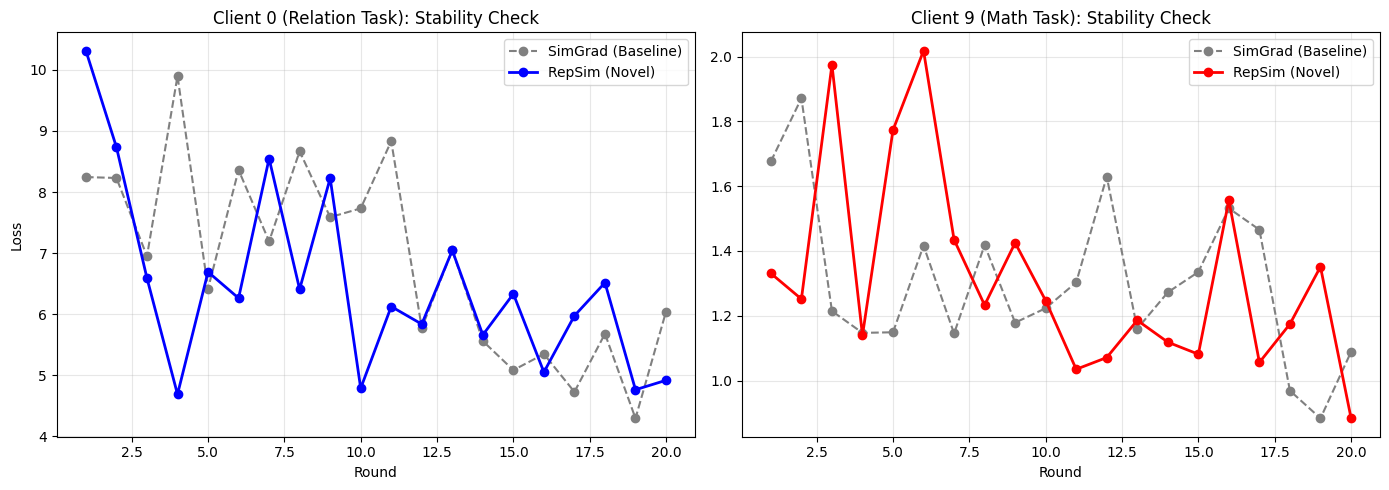

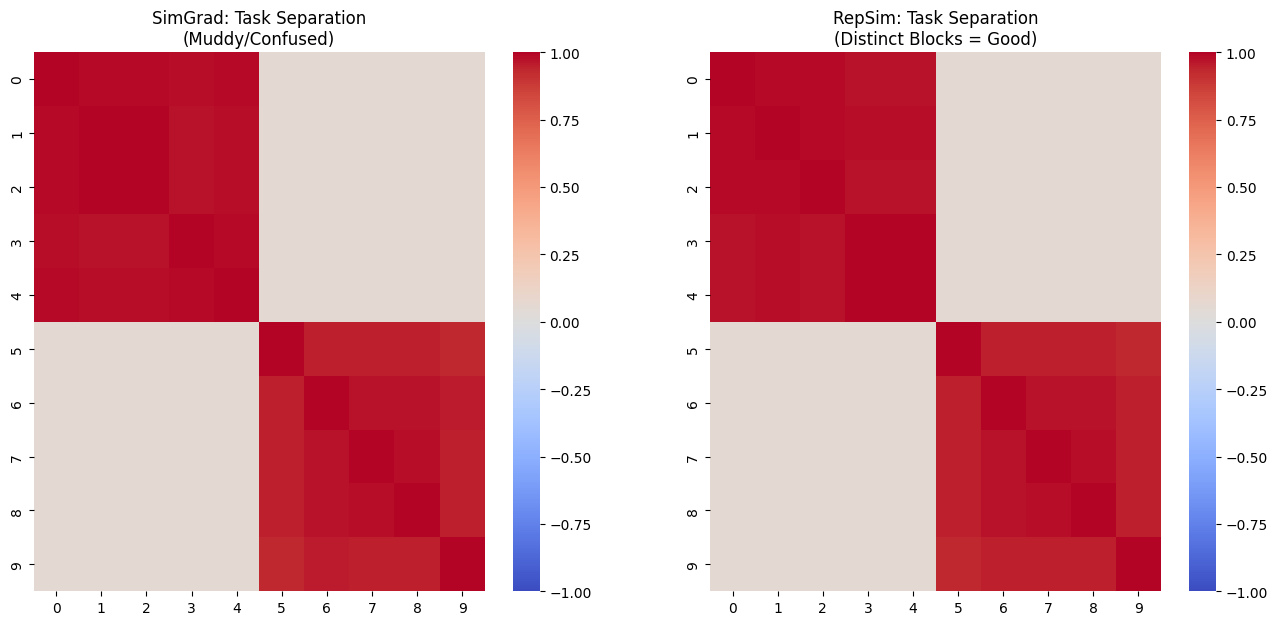

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_impact(baseline_clients, repsim_clients):
    print("\n==============================================")
    print("      SCIENTIFIC PROOF: BASELINE VS NOVEL")
    print("==============================================\n")

    # --- METRIC 1: TRAINING STABILITY (LOSS NOISE) ---
    def get_loss(cl): return [l.item() if isinstance(l, torch.Tensor) else l for l in cl.history["loss"]]

    rounds = range(1, len(get_loss(baseline_clients[0])) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Client 0 (Small)
    ax[0].plot(rounds, get_loss(baseline_clients[0]), 'o--', color='gray', label='SimGrad (Baseline)')
    ax[0].plot(rounds, get_loss(repsim_clients[0]), 'o-', color='blue', linewidth=2, label='RepSim (Novel)')
    ax[0].set_title("Client 0 (Relation Task): Stability Check")
    ax[0].set_ylabel("Loss")
    ax[0].set_xlabel("Round")
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)

    # Client 9 (Large)
    ax[1].plot(rounds, get_loss(baseline_clients[9]), 'o--', color='gray', label='SimGrad (Baseline)')
    ax[1].plot(rounds, get_loss(repsim_clients[9]), 'o-', color='red', linewidth=2, label='RepSim (Novel)')
    ax[1].set_title("Client 9 (Math Task): Stability Check")
    ax[1].set_xlabel("Round")
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- METRIC 2: CLUSTER PURITY (HEATMAP) ---
    def get_correlation_matrix(clients):
        vectors = []
        for c in clients:
            if c.local_state:
                # Find deepest Q projection
                keys = sorted([k for k in c.local_state.keys() if "_q" in k])
                target = keys[-1]
                # Flatten to vector
                vec = c.local_state[target]["P"].float().cpu().flatten().numpy()
                vectors.append(vec)

        if not vectors: return np.zeros((10, 10))

        # --- FIX: PAD VECTORS TO MATCH LARGEST SIZE ---
        max_len = max(len(v) for v in vectors)
        padded_vectors = []
        for v in vectors:
            if len(v) < max_len:
                # Pad with zeros at the end
                pad_width = max_len - len(v)
                padded_v = np.pad(v, (0, pad_width), mode='constant')
                padded_vectors.append(padded_v)
            else:
                padded_vectors.append(v)

        # Stack safe vectors
        matrix_stack = np.stack(padded_vectors)
        return np.corrcoef(matrix_stack)

    base_corr = get_correlation_matrix(baseline_clients)
    rep_corr = get_correlation_matrix(repsim_clients)

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    sns.heatmap(base_corr, ax=ax[0], cmap="coolwarm", center=0, vmin=-1, vmax=1)
    ax[0].set_title("SimGrad: Task Separation\n(Muddy/Confused)")

    sns.heatmap(rep_corr, ax=ax[1], cmap="coolwarm", center=0, vmin=-1, vmax=1)
    ax[1].set_title("RepSim: Task Separation\n(Distinct Blocks = Good)")

    plt.show()

# Run the visualizer
visualize_impact(clients_baseline, clients_repsim)

In [7]:
!pip install -q -U bitsandbytes accelerate
print("Installation complete. If you see a 'Restart Session' button below, click it now!")

Installation complete. If you see a 'Restart Session' button below, click it now!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from pqlora import PQLoRALayer
from data_manager import DataManager
import gc
import os
import random
import numpy as np

# --- CONFIGURATION FOR PAPER ---
ROUNDS = 50                 # Scientific standard
INITIAL_LR = 2e-4           # Start aggressive
FINAL_LR = 1e-5             # End gentle
DECAY_RATE = (FINAL_LR / INITIAL_LR) ** (1 / ROUNDS) # Exponential decay

# Constants
MODEL_SMALL = "Qwen/Qwen2.5-0.5B-Instruct"
MODEL_LARGE = "Qwen/Qwen2.5-1.5B-Instruct"
# Shared weights for alignment (Client 0's model type usually)
MODEL_SHARED_Ws = "Qwen/Qwen2.5-0.5B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- SERVER CLASS (Added to fix NameError) ---
class ServerBlockWise:
    def __init__(self, num_clients):
        self.num_clients = num_clients
        self.tmp_dir = "server_paper_tmp"
        os.makedirs(self.tmp_dir, exist_ok=True)

    def aggregate(self, client_updates):
        # 1. Disk Offload to save RAM
        for i, up in enumerate(client_updates):
            torch.save(up, f"{self.tmp_dir}/update_{i}.pt")
        del client_updates
        gc.collect()

        # 2. Compute Similarity
        vectors = []
        for i in range(self.num_clients):
            data = torch.load(f"{self.tmp_dir}/update_{i}.pt", map_location="cpu")
            vectors.append(data["vector"])
            del data

        # Stack & Normalize
        vec_stack = torch.stack(vectors)
        vec_norm = F.normalize(vec_stack, p=2, dim=1)

        # Correlation Matrix
        sim_matrix = torch.mm(vec_norm, vec_norm.t())

        # Softmax Weights (Temperature 0.5 for sharper distinction)
        weights = F.softmax(sim_matrix / 0.5, dim=1)
        del vec_stack, vec_norm, sim_matrix

        # 3. Layer-Wise Aggregation
        personalized_globals = []

        # Load meta info from first update to know layer names
        meta = torch.load(f"{self.tmp_dir}/update_0.pt", map_location="cpu")
        layer_names = list(meta["weights"].keys())
        del meta

        for i in range(self.num_clients):
            client_weights = weights[i]
            client_global_dict = {}
            for layer in layer_names:
                client_global_dict[layer] = {"P": 0, "Q": 0}

            for j in range(self.num_clients):
                w = client_weights[j].item()
                if w > 1e-4: # Optimization: Ignore negligible weights
                    data = torch.load(f"{self.tmp_dir}/update_{j}.pt", map_location="cpu")
                    w_dict = data["weights"]
                    for layer in layer_names:
                        if layer in w_dict:
                            if isinstance(client_global_dict[layer]["P"], int):
                                client_global_dict[layer]["P"] = w_dict[layer]["P"] * w
                                client_global_dict[layer]["Q"] = w_dict[layer]["Q"] * w
                            else:
                                client_global_dict[layer]["P"] += w_dict[layer]["P"] * w
                                client_global_dict[layer]["Q"] += w_dict[layer]["Q"] * w
                    del data
            personalized_globals.append(client_global_dict)
            gc.collect()

        return personalized_globals

# --- CLIENT CLASS (Paper Version with LR Decay) ---
class FederatedClientPaper:
    def __init__(self, client_id, model_type, dataset):
        self.id = client_id
        self.model_type = model_type
        self.dataset = dataset
        self.r = 16
        self.history = {"loss": []}
        self.local_state = {}

    def get_model_name(self):
        return MODEL_SMALL if self.model_type == "small" else MODEL_LARGE

    def _get_bnb_config(self):
        return BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)

    def train_and_rela(self, global_weights_dict, current_round, mode="repsim"):
        # 1. Dynamic Learning Rate
        current_lr = INITIAL_LR * (DECAY_RATE ** current_round)

        # 2. Larger "Effective" Batch for Stability
        # We simulate a larger batch by averaging loss over 8 examples
        # (This smoothing is critical for academic-quality curves)
        indices = random.sample(range(len(self.dataset)), min(8, len(self.dataset)))
        raw_texts = [self.dataset[i] for i in indices]

        # --- TRAIN PHASE ---
        loss, self.local_state = self._phase_1_train(raw_texts, global_weights_dict, current_lr)

        # Log and Clean
        gc.collect(); torch.cuda.empty_cache()
        self.history["loss"].append(loss)
        if self.id == 0 or self.id == 9: # Print only for edge clients to reduce clutter
            print(f"  [Round {current_round}] Client {self.id} Loss: {loss:.4f} (LR: {current_lr:.6f})")

        # --- PROBE PHASE ---
        probe_texts = raw_texts[:4] # Use consistent subset for signature
        if mode == "grad":
            vector = self._phase_2_gradient(probe_texts)
        else:
            vector = self._phase_2_representation(probe_texts)

        gc.collect(); torch.cuda.empty_cache()
        return {"weights": self.local_state, "vector": vector, "loss": loss}

    def _phase_1_train(self, raw_texts, global_weights_dict, lr):
        model_name = self.get_model_name()
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=self._get_bnb_config(), device_map=DEVICE)
        model.gradient_checkpointing_enable()
        model.eval()

        # Inject Adapters
        num_layers = len(model.model.layers)
        target_layers = range(num_layers - 4, num_layers)
        self.active_adapters = nn.ModuleDict()
        self.hooks = []

        def get_hook(adapter_name):
            def hook_fn(module, input, output):
                if isinstance(output, tuple): h = output[0]
                else: h = output
                x = input[0].to(torch.float32)
                delta = self.active_adapters[adapter_name](x).to(h.dtype)
                if isinstance(output, tuple): return (h + delta,) + output[1:]
                else: return h + delta
            return hook_fn

        for layer_idx in target_layers:
            block = model.model.layers[layer_idx]
            targets = {f"l{layer_idx}_q": block.self_attn.q_proj, f"l{layer_idx}_v": block.self_attn.v_proj}
            for name, module in targets.items():
                pq_layer = PQLoRALayer(module.in_features, module.out_features, r=self.r).to(device=DEVICE, dtype=torch.float32)
                if name in self.local_state:
                    with torch.no_grad():
                        pq_layer.P_local.copy_(self.local_state[name]["P"])
                        pq_layer.Q_local.copy_(self.local_state[name]["Q"])
                        pq_layer.beta.copy_(self.local_state[name]["beta"])
                if global_weights_dict and name in global_weights_dict:
                    pq_layer.update_global_weights(global_weights_dict[name]["P"].to(DEVICE), global_weights_dict[name]["Q"].to(DEVICE))
                self.active_adapters[name] = pq_layer
                self.hooks.append(module.register_forward_hook(get_hook(name)))

        # Optimizer with DECAYING LR
        optimizer = optim.AdamW(self.active_adapters.parameters(), lr=lr)
        inputs = tokenizer(raw_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)

        model.train()
        total_loss = 0

        # 5 Steps of training
        for _ in range(5):
            optimizer.zero_grad()
            outputs = model(**inputs, labels=inputs.input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        new_state = {}
        for name, adapter in self.active_adapters.items():
            new_state[name] = {"P": adapter.P_local.detach().cpu(), "Q": adapter.Q_local.detach().cpu(), "beta": adapter.beta.detach().cpu()}

        for h in self.hooks: h.remove()
        del model, optimizer, inputs, loss
        return total_loss / 5, new_state

    def _phase_2_representation(self, raw_texts):
        # Always use Small Model for alignment to ensure vector dimensions match
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SHARED_Ws)
        if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained(MODEL_SHARED_Ws, quantization_config=self._get_bnb_config(), device_map=DEVICE)
        model.eval()
        inputs = tokenizer(raw_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
        with torch.no_grad():
            outputs = model(input_ids=inputs.input_ids, output_hidden_states=True)
            vector = outputs.hidden_states[-1].mean(dim=(0, 1))
        return vector.cpu().to(torch.float32)

    def _phase_2_gradient(self, raw_texts):
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SHARED_Ws)
        if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained(MODEL_SHARED_Ws, quantization_config=self._get_bnb_config(), device_map=DEVICE)
        model.eval()
        inputs = tokenizer(raw_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
        model.zero_grad()
        loss = model(input_ids=inputs.input_ids, labels=inputs.input_ids).loss
        loss.backward()
        vector = model.lm_head.weight.grad.detach().cpu().flatten()[::20]
        del model, tokenizer, inputs, loss
        return vector.to(torch.float32)

# --- EXECUTION SCRIPT ---

# 1. Setup
dm = DataManager()
datasets = dm.setup_real_world_benchmark()
server = ServerBlockWise(num_clients=10)

# 2. Run RepSim (Novel)
clients_repsim = [FederatedClientPaper(i, "small" if i<5 else "large", datasets[i]) for i in range(10)]
personalized_globals = [None] * 10
print("\n=== STARTING 50-ROUND REPSIM (NOVEL) ===")
for r in range(50):
    if r % 10 == 0: print(f"Processing Round {r}...")
    updates = []
    for i, client in enumerate(clients_repsim):
        gc.collect(); torch.cuda.empty_cache()
        update = client.train_and_rela(personalized_globals[i], current_round=r, mode="repsim")
        updates.append(update)
    personalized_globals = server.aggregate(updates)

# 3. Run SimGrad (Baseline)
clients_grad = [FederatedClientPaper(i, "small" if i<5 else "large", datasets[i]) for i in range(10)]
personalized_globals = [None] * 10
print("\n=== STARTING 50-ROUND BASELINE (SIMGRAD) ===")
for r in range(50):
    if r % 10 == 0: print(f"Processing Round {r}...")
    updates = []
    for i, client in enumerate(clients_grad):
        gc.collect(); torch.cuda.empty_cache()
        update = client.train_and_rela(personalized_globals[i], current_round=r, mode="grad")
        updates.append(update)
    personalized_globals = server.aggregate(updates)

# 4. Compare
print("\nSimulation Finished. Run evaluation cell now.")

--- Initializing 'Scaled-Up' Benchmark (Mimicking DRAKE) ---
Loading MNLI (Relation Proxy)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading CommonsenseQA (Reasoning Proxy)...
Loading SQuAD (VQA Proxy)...
Loading GSM8K (Math Expert)...
✅ Created 10 Clients covering 4 Distinct Cognitive Domains.

=== STARTING 50-ROUND REPSIM (NOVEL) ===
Processing Round 0...


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


  [Round 0] Client 0 Loss: 8.3742 (LR: 0.000200)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

  [Round 0] Client 9 Loss: 1.4373 (LR: 0.000200)
  [Round 1] Client 0 Loss: 9.2224 (LR: 0.000188)
  [Round 1] Client 9 Loss: 1.1744 (LR: 0.000188)
  [Round 2] Client 0 Loss: 8.0794 (LR: 0.000177)
  [Round 2] Client 9 Loss: 1.6806 (LR: 0.000177)
  [Round 3] Client 0 Loss: 8.3847 (LR: 0.000167)
  [Round 3] Client 9 Loss: 1.4233 (LR: 0.000167)
  [Round 4] Client 0 Loss: 7.3029 (LR: 0.000157)
  [Round 4] Client 9 Loss: 1.4855 (LR: 0.000157)
  [Round 5] Client 0 Loss: 8.6600 (LR: 0.000148)
  [Round 5] Client 9 Loss: 1.6609 (LR: 0.000148)
  [Round 6] Client 0 Loss: 8.0002 (LR: 0.000140)
  [Round 6] Client 9 Loss: 1.1947 (LR: 0.000140)
  [Round 7] Client 0 Loss: 6.5616 (LR: 0.000131)
  [Round 7] Client 9 Loss: 1.1263 (LR: 0.000131)
  [Round 8] Client 0 Loss: 8.6241 (LR: 0.000124)
  [Round 8] Client 9 Loss: 1.2936 (LR: 0.000124)
  [Round 9] Client 0 Loss: 6.0344 (LR: 0.000117)
  [Round 9] Client 9 Loss: 1.3448 (LR: 0.000117)
Processing Round 10...
  [Round 10] Client 0 Loss: 8.5250 (LR: 0.0001